# Predicting CLTV and Customer Repeat with Machine Learning for Shopify 

#### A Data Science Analysis Project by Benjamin N. Bellman 

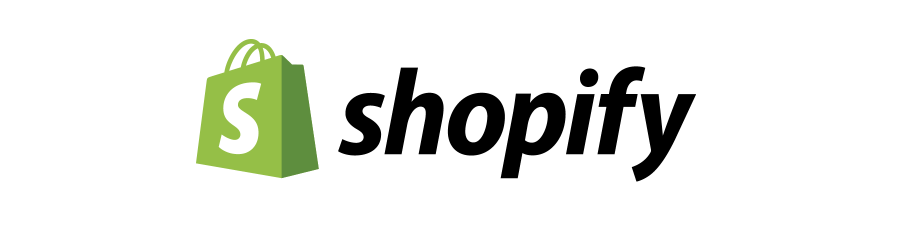

### Project Table of Contents: 
<br> 
    
**I. INTRODUCTION \& PRELIMINARY ANALYSIS**
- 1. Project Purpose 
- 2. Loading \& Previewing Data   
- 3. Data Wrangling  
- 4. Preliminary EDA 
 
**II. DATA WRANGLING**  
- 1. Cleaning up data. 
- 2. Creating 3 separate dataframes.
- 3. Creating the final 1 year CLTV Table.

**III. EXPLORATORY DATA ANALYSIS**     
- 1. Loading an Previewing the New Table  
- 2. Exploring relationships of variables on Post First Week Spend 

**IV. PREPROCESSING AND MODELLING**
- 1. Linear Models
- 2. Classification Models


## Part 3: PreProcessing and Modelling

### Loading our Packages and DataFrame

In [1]:
## We start by importing the packages we will use.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb 

from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import mean_squared_error as mse, r2_score, mean_absolute_error as mae, f1_score, fbeta_score 
from sklearn.metrics import plot_confusion_matrix,classification_report, balanced_accuracy_score, recall_score
from sklearn.metrics import roc_auc_score, log_loss,matthews_corrcoef, ConfusionMatrixDisplay

from io import StringIO 
from IPython.display import Image,HTML 
import pydotplus
import graphviz
import shap

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
## We Load and preview our customer_cltv dataframe from the previouse chapter 
customer_cltv = pd.read_csv('.\..\..\..\cleaned_data.csv',index_col=0)
customer_cltv.head()

,CustomerID,pfw_spent,fw_nb_orders,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,fw_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range
0,Anonymous13455,1257.80,1,1,50.0,0,6,0,M,0,0,MW,high
1,Anonymous2142,436.15,1,1,48.0,0,5,0,L,0,0,NE,high
2,Anonymous4843,1052.75,2,2,96.0,0,10,0,S,1,0,W,high
3,Anonymous11225,728.10,1,1,16.0,0,1,1,No size,0,0,MW,low
4,Anonymous540,1114.75,1,1,50.0,0,1,0,XS,0,0,W,high


## Preprocessing & Feature Engineering: 

In [3]:
## Drop some error rows (no spending on the first week)
customer_cltv = customer_cltv[customer_cltv.loc[:,'fw_total_spent'] > 0] 

In [4]:
## We change the pfw_spent column and create a new target column: repeat
customer_cltv['repeat'] = np.where(customer_cltv['pfw_spent'] > 0,1,0)
customer_cltv.drop(columns='pfw_spent',inplace=True)
customer_cltv.head()

,CustomerID,fw_nb_orders,fw_nb_items,fw_total_spent,fw_used_coupon,first_order_month,fw_purchased_accessory,first_item_size,accepts_marketing,wealthy_zip,region,first_item_price_range,repeat
0,Anonymous13455,1,1,50.0,0,6,0,M,0,0,MW,high,1
1,Anonymous2142,1,1,48.0,0,5,0,L,0,0,NE,high,1
2,Anonymous4843,2,2,96.0,0,10,0,S,1,0,W,high,1
3,Anonymous11225,1,1,16.0,0,1,1,No size,0,0,MW,low,1
4,Anonymous540,1,1,50.0,0,1,0,XS,0,0,W,high,1


<br> **Drop variables that we found to be heavily correlated with other or irrelevant through the previous step of EDA**
- **fw_nb_items** is highly correlated with fw_total_spent (c=0.94)
- **fw_nb_orders** is very unbalanced (~ 95% customers only made 1 order the first week)
- **region** was found to be insignificant based on several steps of statistical analysis
- **fw_purchased_accessory** is logically redundant with first_item_size


In [5]:
customer_cltv.drop(columns=['fw_nb_items', 'region', 'fw_nb_orders', 'fw_purchased_accessory'], inplace = True)

<br> **Modify variables based on findings from EDA**
- **first_order_month** can be modified to be 2 categories: February-June vs rest of the year
- **first_item size** can be modified to be 2 categories: Large Size and Smaller Sizes

In [6]:
## First Item Month 
customer_cltv['first_order_feb_june'] = customer_cltv['first_order_month'].apply(lambda x: x in [2, 3, 4, 5, 6])
customer_cltv['first_order_feb_june'].replace({True:1,False:0}, inplace = True)
customer_cltv.drop(columns=['first_order_month'], inplace = True)

## First Item Size: 
customer_cltv['large_size'] = customer_cltv['first_item_size'].apply(lambda x: x in ['XL','L','M'])
customer_cltv['large_size'].replace({True:1,False:0}, inplace = True)
customer_cltv.drop(columns=['first_item_size'], inplace = True)
customer_cltv.head()

,CustomerID,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_item_price_range,repeat,first_order_feb_june,large_size
0,Anonymous13455,50.0,0,0,0,high,1,1,1
1,Anonymous2142,48.0,0,0,0,high,1,1,1
2,Anonymous4843,96.0,0,1,0,high,1,0,0
3,Anonymous11225,16.0,0,0,0,low,1,0,0
4,Anonymous540,50.0,0,0,0,high,1,0,0


#### We create dummy variables for our categorical variables.

In [7]:
## We create dummy variables for prize range of items. 
categorical_cols = ['first_item_price_range']
dummies_encoded = pd.get_dummies(customer_cltv[categorical_cols].astype(str),drop_first=True)
customer_cltv = pd.concat([customer_cltv,dummies_encoded], axis =1)
customer_cltv.drop(columns=['first_item_price_range'],inplace = True)
customer_cltv.head()

,CustomerID,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,repeat,first_order_feb_june,large_size,first_item_price_range_low,first_item_price_range_medium
0,Anonymous13455,50.0,0,0,0,1,1,1,0,0
1,Anonymous2142,48.0,0,0,0,1,1,1,0,0
2,Anonymous4843,96.0,0,1,0,1,0,0,0,0
3,Anonymous11225,16.0,0,0,0,1,0,0,1,0
4,Anonymous540,50.0,0,0,0,1,0,0,0,0


In [8]:
## We get our feature variables and target variables
X = customer_cltv.drop(columns=['CustomerID','repeat'])
y = customer_cltv['repeat']
print(X.shape, y.shape)

(10590, 8) (10590,)


In [9]:
## We use a scaler to scale the feature variables which are not categorical: 
cols_to_scale = ['fw_total_spent']
scaler = StandardScaler()
scaler.fit(X[cols_to_scale])

X_scaled = scaler.transform(X[cols_to_scale])
for ind, col in enumerate(cols_to_scale):
    X[col] = X_scaled[:,ind]
X.head()

,fw_total_spent,fw_used_coupon,accepts_marketing,wealthy_zip,first_order_feb_june,large_size,first_item_price_range_low,first_item_price_range_medium
0,-0.347324,0,0,0,1,1,0,0
1,-0.389530,0,0,0,1,1,0,0
2,0.623424,0,1,0,0,0,0,0
3,-1.064833,0,0,0,0,0,1,0
4,-0.347324,0,0,0,0,0,0,0


0    7714
1    2876
Name: repeat, dtype: int64


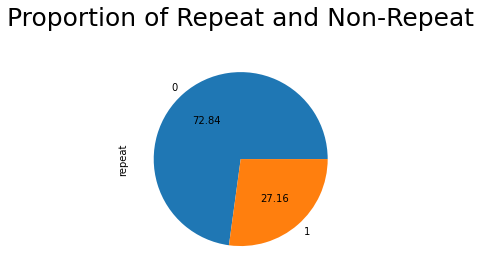

In [10]:
## Look at the balance of the data: Only 27% of our customers are repeat, the non-repeats are over represented.
## This is an example of an imbalanced dataset. 
print(y.value_counts())
y.value_counts().plot.pie(autopct='%.2f')
plt.title('Proportion of Repeat and Non-Repeat', pad =25, fontsize =25)
plt.show()

In [11]:
## We split our data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42, stratify =y )
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7942, 8) (2648, 8) (7942,) (2648,)


<AxesSubplot:ylabel='repeat'>

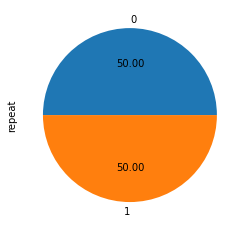

In [12]:
## We proceed with Random Undersampling:
rus = RandomUnderSampler(sampling_strategy = 1, random_state = 42)
X_train, y_train = rus.fit_resample(X_train,y_train)
y_train.value_counts().plot.pie(autopct='%.2f')

<AxesSubplot:ylabel='repeat'>

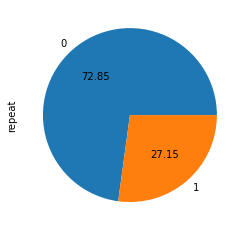

In [13]:
y_test.value_counts().plot.pie(autopct='%.2f')

# Classification Models
<br> In the previous models, our target feature was **continuous**. We will be treating pwf as a **discrete**.
<br> **We will be using 7 different classification models:**
- 1) Logistic Regression 
- 2) Random Forests
- 3) Gradient Boosting
- 4) AdaBoost

## 1) Logistic Regression 

In [14]:
## We instantiate a logistic regression model and use GridSearchCV to find the best parameters. 
log_reg = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
             'l1_ratio': [0,.5,1],
             'penalty':['none','l1','l2','elasticnet']
             }
lr_cv = GridSearchCV(log_reg, param_grid, cv=10, scoring='roc_auc')
lr_cv.fit(X_train,y_train)

## We print the metrics: 
print('Best Estimator:' +str(lr_cv.best_estimator_))
print('Best Params:' +str(lr_cv.best_params_))
print('Best Score:' +str(lr_cv.best_score_))


############################################ GRIDSEARCHCV_RESULTS ################################################## 

## Scoring = 'f1': 
'''
Best Estimator:LogisticRegression(C=1, l1_ratio=0)
Best Params:{'C': 1, 'l1_ratio': 0, 'penalty': 'l2'}
Best Score:0.5678594164426407
'''

## Scoring = 'roc_auc': 
'''
Best Estimator:LogisticRegression(C=0.001, l1_ratio=0)
Best Params:{'C': 0.001, 'l1_ratio': 0, 'penalty': 'l2'}
Best Score:0.5945432377899003
'''

## Scoring = 'accuracy': 
'''
Best Estimator:LogisticRegression(C=0.001, l1_ratio=0)
Best Params:{'C': 0.001, 'l1_ratio': 0, 'penalty': 'l2'}
Best Score:0.5646719515339005
'''

## Scoring = 'precision': 
'''
Best Estimator:LogisticRegression(C=0.001, l1_ratio=0)
Best Params:{'C': 0.001, 'l1_ratio': 0, 'penalty': 'l2'}
Best Score:0.5758716780229738
'''
######################################################################################################################

## With the best parameters, we re-instantiate the model, fit and predict the outcomes. 
best_lreg = LogisticRegression(C = 0.001, l1_ratio= 0, penalty = 'l2')

Best Estimator:LogisticRegression(C=0.001, l1_ratio=0)
Best Params:{'C': 0.001, 'l1_ratio': 0, 'penalty': 'l2'}
Best Score:0.5945432377899003


## 2 Random Forests:

In [15]:
## We use GridSearchCV to find the best hyperparameters of RandomForest. 
#'''
rfc = RandomForestClassifier(random_state = 42)
param_grid = { 
    'n_estimators': [10, 25, 50, 100, 200],
    'max_features': ['sqrt', 'auto', 'log2'],
    'criterion': ['gini','entropy'],
    'max_depth' : [2,4,5,6,7,8],
    'bootstrap':['False', 'True']
}

rfc_GS = RandomizedSearchCV(rfc, param_grid, cv=5, scoring='roc_auc', random_state = 42)
rfc_GS.fit(X_train,y_train)

##Let's look at the results  for Grid Search CV 

print('Best Estimator:' +str(rfc_GS.best_estimator_))
print('Best Params:' +str(rfc_GS.best_params_))
print('Best Score:' +str(rfc_GS.best_score_))
#'''

############################################ GRIDSEARCHCV_RESULTS ################################################## 

## Scoring = 'f1': 
'''
Best Estimator:RandomForestClassifier(bootstrap='False', max_depth=4, max_features='sqrt',
                       n_estimators=10, random_state=42)
Best Params:{'n_estimators': 10, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'gini', 'bootstrap': 'False'}
Best Score:0.6176162851525782
'''

## Scoring = 'roc_auc': 
'''
Best Estimator:RandomForestClassifier(bootstrap='False', max_depth=4, max_features='sqrt',
                       n_estimators=10, random_state=42)
Best Params:{'n_estimators': 10, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'gini', 'bootstrap': 'False'}
Best Score:0.5907871900612236
'''

## Scoring = 'accuracy': 
'''
Best Estimator:RandomForestClassifier(bootstrap='True', max_depth=5, max_features='log2',
                       n_estimators=200, random_state=42)
Best Params:{'n_estimators': 200, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'gini', 'bootstrap': 'True'}
Best Score:0.5760327245646628
'''

## Scoring = 'precision': 
'''
Best Estimator:RandomForestClassifier(bootstrap='True', max_depth=5, max_features='log2',
                       n_estimators=200, random_state=42)
Best Params:{'n_estimators': 200, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'gini', 'bootstrap': 'True'}
Best Score:0.5628478755194339
'''
######################################################################################################################

## With the best parameters, we re-instantiate the model, fit and predict the probabilities. 
rfc_best = RandomForestClassifier(bootstrap= False, criterion= 'gini', max_depth= 4, 
                                  max_features= 'sqrt', n_estimators= 10, random_state = 42)

Best Estimator:RandomForestClassifier(bootstrap='False', max_depth=4, max_features='sqrt',
                       n_estimators=10, random_state=42)
Best Params:{'n_estimators': 10, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'gini', 'bootstrap': 'False'}
Best Score:0.5907871900612236


In [16]:
## We can see the feature importances in the model below...
rfc_best.fit(X_train,y_train)
features_best = pd.DataFrame(rfc_best.feature_importances_, index = X_train.columns, 
                      columns=['importance']).sort_values('importance', ascending=False)
features_best

,importance
fw_total_spent,0.604818
first_item_price_range_low,0.123177
large_size,0.103049
first_order_feb_june,0.097607
first_item_price_range_medium,0.026908
fw_used_coupon,0.023177
accepts_marketing,0.011044
wealthy_zip,0.010219


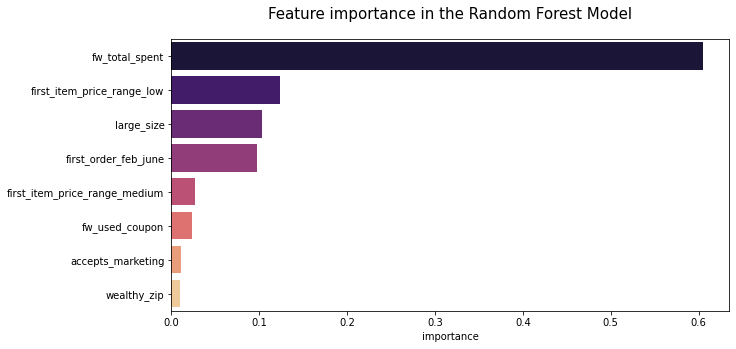

In [17]:
## ... and we can plot them. 
plt.figure(figsize=(10,5))
sns.color_palette("magma", as_cmap=True)
sns.barplot(y = features_best.index, x = features_best['importance'],palette='magma')
plt.title('Feature importance in the Random Forest Model', pad = 20, fontsize = 15)
plt.show()

## 3) Gradient Boosting:

In [18]:
## We use GridSearchCV to find the best hyperparameters for Gradient Boosting
#'''
gbc = GradientBoostingClassifier(random_state = 42)
param_grid = { 
    'loss': ['exponential','deviance'],
    'n_estimators': [1,2,5,10,20,100],
    'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
    'max_depth' : [2,3,4,5,6,8,10],
}

gbc_GS = RandomizedSearchCV(gbc, param_grid, cv=5, scoring='roc_auc', random_state = 42)
gbc_GS.fit(X_train,y_train)

##Let's look at the results  for Grid Search CV 
print('Best Estimator:' +str(gbc_GS.best_estimator_))
print('Best Params:' +str(gbc_GS.best_params_))
print('Best Score:' +str(gbc_GS.best_score_))
#'''

############################################ GRIDSEARCHCV_RESULTS ################################################## 

## Scoring = 'f1': 
'''
Best Estimator:GradientBoostingClassifier(criterion='mae', loss='exponential', max_depth=8,
                           n_estimators=2, random_state=42)
Best Params:{'n_estimators': 2, 'max_depth': 8, 'loss': 'exponential', 'criterion': 'mae'}
Best Score:0.6195068274891854
'''

## Scoring = 'roc_auc': 
'''
Best Estimator:GradientBoostingClassifier(criterion='mae', n_estimators=5, random_state=42)
Best Params:{'n_estimators': 5, 'max_depth': 3, 'loss': 'deviance', 'criterion': 'mae'}
Best Score:0.5932534128381212
'''

## Scoring = 'accuracy': 
'''
Best Estimator:GradientBoostingClassifier(criterion='mae', n_estimators=5, random_state=42)
Best Params:{'n_estimators': 5, 'max_depth': 3, 'loss': 'deviance', 'criterion': 'mae'}
Best Score:0.5848384070030355
'''

## Scoring = 'precision': 
'''
Best Estimator:GradientBoostingClassifier(criterion='mae', n_estimators=5, random_state=42)
Best Params:{'n_estimators': 5, 'max_depth': 3, 'loss': 'deviance', 'criterion': 'mae'}
Best Score:0.5754323297924631
'''
######################################################################################################################

## We  fit the Predictor.
gbc_best = GradientBoostingClassifier(criterion= 'mae', max_depth= 3, 
                                      max_features= 'sqrt', n_estimators= 5, loss ='deviance',
                                      random_state = 42)

Best Estimator:GradientBoostingClassifier(criterion='mae', n_estimators=5, random_state=42)
Best Params:{'n_estimators': 5, 'max_depth': 3, 'loss': 'deviance', 'criterion': 'mae'}
Best Score:0.5932534128381212


## 4) ADABOOST 

In [19]:
## We use GridSearchCV to find the best parameters to maximize roc_auc. 
#'''
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42),random_state=42)

parameters = {'base_estimator__max_depth':[i for i in range(2,11,2)],
              'base_estimator__min_samples_leaf':[5,10],
              'n_estimators':[10,50,250,1000],
              'learning_rate':[0.01,0.1]}

ada_GS = RandomizedSearchCV(ada, parameters,verbose=3,scoring='roc_auc',n_jobs=-1, random_state = 42)
ada_GS.fit(X_train,y_train)

print('Best Estimator:' +str(ada_GS.best_estimator_))
print('Best Params:' +str(ada_GS.best_params_))
print('Best Score:' +str(ada_GS.best_score_))
#'''

############################################ GRIDSEARCHCV_RESULTS ################################################## 

## Scoring = 'f1': 
'''
Best Estimator:AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,min_samples_leaf=10,random_state=42),
                   learning_rate=0.01, n_estimators=250, random_state=42)
Best Params:{'n_estimators': 250, 'learning_rate': 0.01, 'base_estimator__min_samples_leaf': 10, 
             'base_estimator__max_depth': 2}
Best Score:0.6072046924748443
'''

## Scoring = 'roc_auc': 
'''
Best Estimator:AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,min_samples_leaf=10,random_state=42),
                   learning_rate=0.01, n_estimators=250, random_state=42)
Best Params:{'n_estimators': 250, 'learning_rate': 0.01, 'base_estimator__min_samples_leaf': 10, 
             'base_estimator__max_depth': 2}
Best Score:0.5933763754980264
'''

## Scoring = 'accuracy': 
'''
Best Estimator:AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,min_samples_leaf=10,random_state=42),
                   learning_rate=0.01, n_estimators=250, random_state=42)
Best Params:{'n_estimators': 250, 'learning_rate': 0.01, 'base_estimator__min_samples_leaf': 10, 
             'base_estimator__max_depth': 2}
Best Score:0.5730189029259073
'''

## Scoring = 'precision': 
'''
Best Estimator:AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2, min_samples_leaf=10, random_state=42),
                   learning_rate=0.01, n_estimators=250, random_state=42)
Best Params:{'n_estimators': 250, 'learning_rate': 0.01, 'base_estimator__min_samples_leaf': 10, 
             'base_estimator__max_depth': 2}
Best Score:0.562067574901959
'''
######################################################################################################################

## We fit with the best parameters. 
ada_best = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2, min_samples_leaf=10,random_state=42),
                                                           learning_rate=0.01, n_estimators=250, random_state=42)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Estimator:AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=10,
                                                         random_state=42),
                   learning_rate=0.01, n_estimators=250, random_state=42)
Best Params:{'n_estimators': 250, 'learning_rate': 0.01, 'base_estimator__min_samples_leaf': 10, 'base_estimator__max_depth': 2}
Best Score:0.5933763754980264


## Plotting ROC and AUC

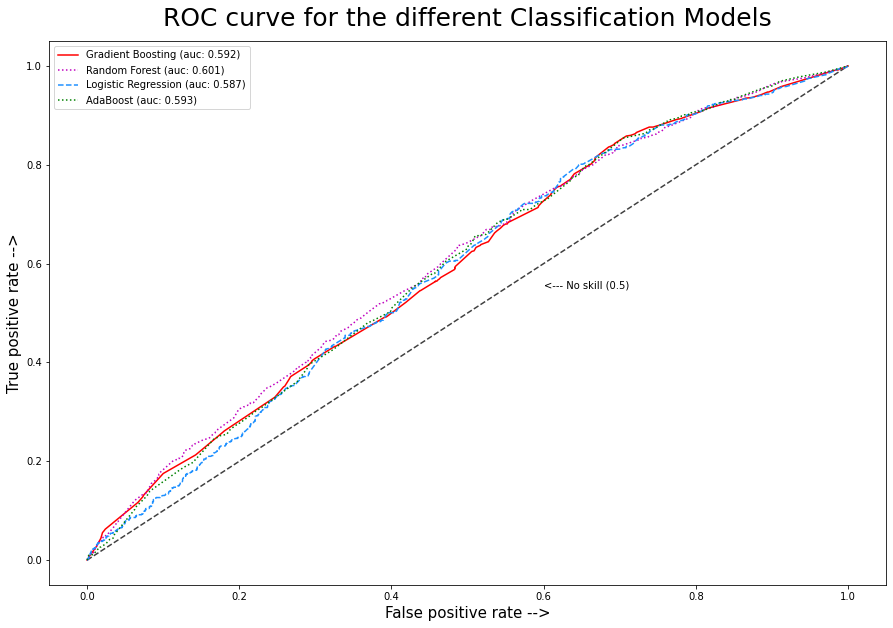

In [20]:
## We plot the ROC and AUC 
names = ["Gradient Boosting","Random Forest","Logistic Regression",'AdaBoost']
clfs = [gbc_best,rfc_best,best_lreg,ada_best]

## Parameters for the plotting 
linestyles =['-',':','--',':','-','--',':','-','-']
colors = ['r','m','dodgerblue','g','darkorange','limegreen', 'deeppink','navy','y']

plt.figure(figsize=(15,10))
counter = 0
for name,clf in zip(names,clfs):
    clf.fit(X_train,y_train)
    y_proba = clf.predict_proba(X_test)[:,1]
    #print("Roc AUC:"+name, roc_auc_score(y_test, clf.predict_proba(X_test)[:,1],average='macro')) ## Can uncomment
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=name+ ' (auc: %0.3f)' %roc_auc_score(y_test, clf.predict_proba(X_test)[:,1],average='macro'),
             linestyle=linestyles[counter], c=colors[counter])
    counter += 1
## Plot a straight line that goes throug
lims = [np.min([0.0, 0.0]),  np.max([1.0, 1.0])]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0, c='black', linestyle ='--')

plt.xlabel('False positive rate -->', fontsize = 15)
plt.ylabel('True positive rate -->', fontsize = 15)
plt.title('ROC curve for the different Classification Models', pad =15, fontsize = 25)
plt.legend(loc='best')
plt.savefig('roc_auc_classification_4_models_resampling.png')
plt.annotate('<--- No skill (0.5)',xy=(0.6,0.55))
plt.show()  

## Visualizing the Precision / Recall Tradeoff

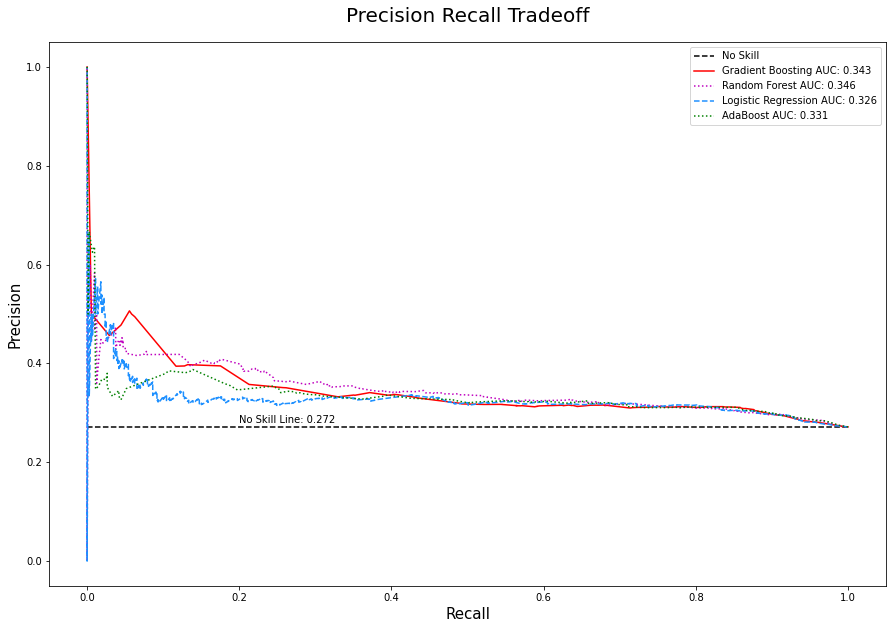

In [21]:
## Plotting the Precision / Recall Tradeoff 

names = ["Gradient Boosting","Random Forest","Logistic Regression","AdaBoost"]
models = [gbc_best,rfc_best,best_lreg,ada_best]
linestyles =['-',':','--',':','-','--',':','-','-']
colors = ['r','m','dodgerblue','g','darkorange','limegreen', 'deeppink','navy','y']

plt.figure(figsize=(15,10))

## Plotting the no-skill line. 
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', c='black')

counter = 0
for name, model in zip(names,models):
    precision,recall,thresholds = precision_recall_curve(y_test,model.predict_proba(X_test)[:,1])
    plt.plot(recall,precision,color=colors[counter], 
             linestyle=linestyles[counter], 
             label = name  +' AUC: %.3f'%auc(recall,precision))
    counter +=1


plt.title('Precision Recall Tradeoff', pad=20, fontsize = 20)
plt.xlabel('Recall', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)
plt.annotate('No Skill Line: '+str(round(no_skill,3)),(0.2,0.28), fontsize =10)
plt.legend()
plt.savefig('precision_recall_4_models_resampling.png')
plt.show()

## Evaluating our Models and Plotting the Confusion Matrices: 

Gradient Boosting Model Metrics:
ROC_AUC_SCORE: 0.592
Accuracy: 0.53
Precision: 0.315
Recall: 0.624
F1-Score: 0.419
Log Loss Score: 16.239
MCC: 0.106


Random Forest Model Metrics:
ROC_AUC_SCORE: 0.601
Accuracy: 0.512
Precision: 0.318
Recall: 0.697
F1-Score: 0.437
Log Loss Score: 16.865
MCC: 0.126


Logistic Regression Model Metrics:
ROC_AUC_SCORE: 0.587
Accuracy: 0.579
Precision: 0.319
Recall: 0.484
F1-Score: 0.384
Log Loss Score: 14.544
MCC: 0.089


AdaBoost Model Metrics:
ROC_AUC_SCORE: 0.593
Accuracy: 0.534
Precision: 0.323
Recall: 0.656
F1-Score: 0.433
Log Loss Score: 16.109
MCC: 0.129




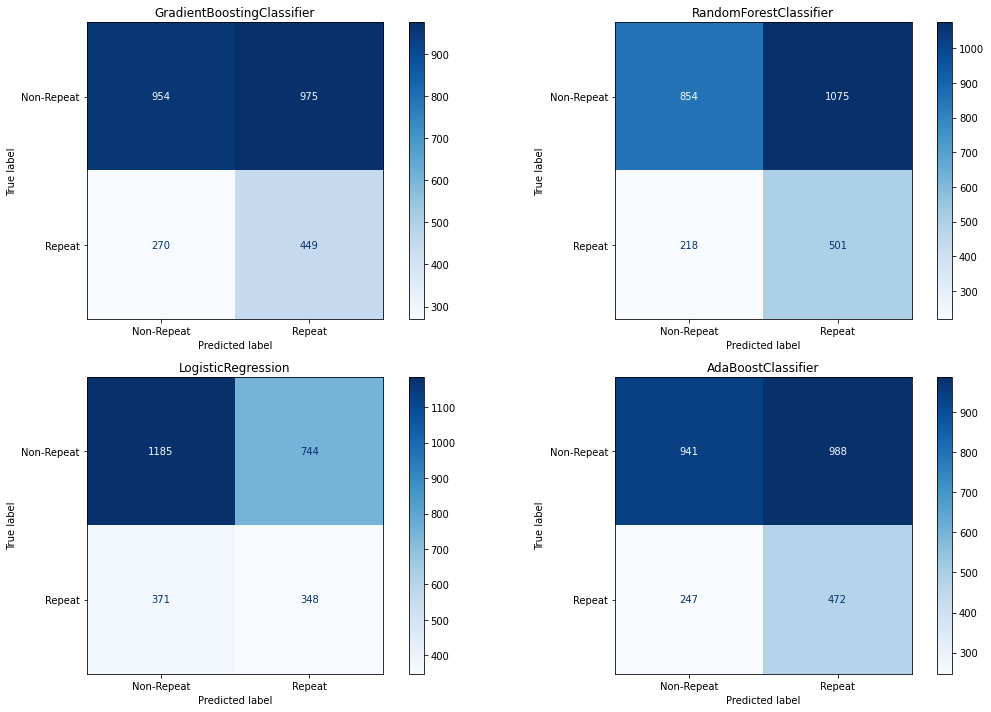

In [22]:
names = ["Gradient Boosting","Random Forest","Logistic Regression","AdaBoost"]
models = [gbc_best,rfc_best,best_lreg,ada_best]

counter = 0
for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
    print('{} Model Metrics:'.format(names[counter]))
    print('ROC_AUC_SCORE: ' + str(round(roc_auc,3)))
    print('Accuracy: ' + str(round(accuracy_score(y_test,y_pred),3)))
    print('Precision: '+ str(round(precision_score(y_test,y_pred),3)))
    print('Recall: ' + str(round(recall_score(y_test,y_pred),3)))
    print('F1-Score: ' + str(round(f1_score(y_test,y_pred),3)))
    print('Log Loss Score: ' + str(round(log_loss(y_test,y_pred),3)))
    print('MCC: ' + str(round(matthews_corrcoef(y_test,y_pred),3)))
    print("\n")
    counter +=1
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
for model, ax in zip(models, axes.flatten()):
    plot_confusion_matrix(model, 
                            X_test, 
                            y_test, 
                            ax=ax, 
                            cmap='Blues',
                            display_labels=['Non-Repeat','Repeat'])
    ax.title.set_text(type(model).__name__)

plt.tight_layout()  
plt.show()


## Measuring F-1 Scores 

In [23]:
## Getting the optimal thresholds for each model and printing out the classification report for the best score. 

## Define function to convert postitive probabilities at threshold to labels. 
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

thresholds = np.arange(0, 1, 0.001)

## Predict Probabilitities
probs_log_best = best_lreg.predict_proba(X_test)[:,1]
probs_rfc_best = rfc_best.predict_proba(X_test)[:,1]
probs_gbc_best = gbc_best.predict_proba(X_test)[:,1]
probs_ada_best = ada_best.predict_proba(X_test)[:,1]


## Thresholds for f1_score

log_scores_best = [f1_score(y_test,to_labels(probs_log_best , t)) for t in thresholds]
rfc_scores_best = [f1_score(y_test,to_labels(probs_rfc_best , t)) for t in thresholds]
gbc_scores_best = [f1_score(y_test,to_labels(probs_gbc_best , t)) for t in thresholds]
ada_scores_best = [f1_score(y_test,to_labels(probs_ada_best , t)) for t in thresholds]

ix_log_best = np.argmax(log_scores_best)
ix_rfc_best = np.argmax(rfc_scores_best)
ix_gbc_best = np.argmax(gbc_scores_best)
ix_ada_best = np.argmax(ada_scores_best)

print('Log Best Threshold=%.3f, Best F-Score=%.5f' % (thresholds[ix_log_best], log_scores_best[ix_log_best]))
print('RFC Best Threshold=%.3f, Best F-Score=%.5f' % (thresholds[ix_rfc_best], rfc_scores_best[ix_rfc_best]))
print('GBC Best Threshold=%.3f, Best F-Score=%.5f' % (thresholds[ix_gbc_best], gbc_scores_best[ix_gbc_best]))
print('ADA Best Threshold=%.3f, Best F-Score=%.5f' % (thresholds[ix_ada_best], ada_scores_best[ix_ada_best]))


############################################### THRESHOLDING RESULT #######################################################


## 1) Best F-Score with GRIDSEARCHCV = ROC_AUC : 

'''
Log Best Threshold=0.223, Best F-Score=0.44707
RFC Best Threshold=0.252, Best F-Score=0.45364
GBC Best Threshold=0.258, Best F-Score=0.45465
ADA Best Threshold=0.402, Best F-Score=0.45429
'''

## 2) Best F-Score with GRIDSEARCHCV = F1-Score : 




## 3) Best 

Log Best Threshold=0.479, Best F-Score=0.45215
RFC Best Threshold=0.470, Best F-Score=0.45236
GBC Best Threshold=0.474, Best F-Score=0.45525
ADA Best Threshold=0.482, Best F-Score=0.45617


'\nLog Best Threshold=0.223, Best F-Score=0.44707\nRFC Best Threshold=0.252, Best F-Score=0.45364\nGBC Best Threshold=0.258, Best F-Score=0.45465\nADA Best Threshold=0.402, Best F-Score=0.45429\n'

## Classification Report and Confusion Matrix


 GBCBoost Classification Report: 

              precision    recall  f1-score   support

           0       0.78      0.49      0.61      1929
           1       0.32      0.62      0.42       719

    accuracy                           0.53      2648
   macro avg       0.55      0.56      0.51      2648
weighted avg       0.65      0.53      0.55      2648


 GBCBoost Confusion Matrix: 



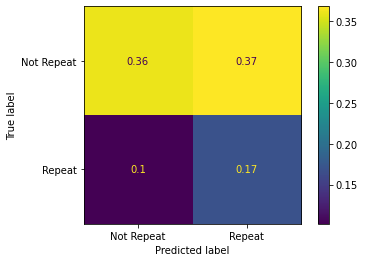

In [24]:
## We get the classification report.
print("\n GBCBoost Classification Report: \n")
print(classification_report(y_test,(gbc_best.predict_proba(X_test)[:,1] >=0.5).astype(int)))

## We get the confusion matrix for the best threshold of the best model. 
print("\n GBCBoost Confusion Matrix: \n")
matrix = confusion_matrix(y_test,(gbc_best.predict_proba(X_test)[:,1] >= 0.5).astype(int))
matrix = matrix.astype('float') / len(y_test)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Not Repeat','Repeat'])
disp.plot()
plt.show()


 GBCBoost Classification Report: 

              precision    recall  f1-score   support

           0       0.80      0.44      0.57      1929
           1       0.32      0.70      0.44       719

    accuracy                           0.51      2648
   macro avg       0.56      0.57      0.50      2648
weighted avg       0.67      0.51      0.53      2648


 GBCBoost Confusion Matrix: 



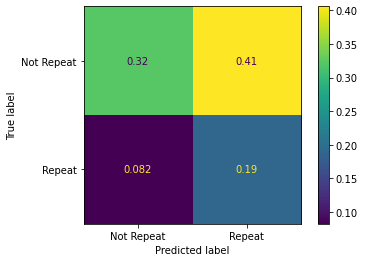

In [25]:
## We get the classification report for Random Forest.
print("\n GBCBoost Classification Report: \n")
print(classification_report(y_test,(rfc_best.predict_proba(X_test)[:,1] >=0.5).astype(int)))

## We get the confusion matrix for the best threshold of the best model. 
print("\n GBCBoost Confusion Matrix: \n")
matrix = confusion_matrix(y_test,(rfc_best.predict_proba(X_test)[:,1] >= 0.5).astype(int))
matrix = matrix.astype('float') / len(y_test)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Not Repeat','Repeat'])
disp.plot()
plt.show()


 AdaBoost Classification Report: 

              precision    recall  f1-score   support

           0       0.76      0.61      0.68      1929
           1       0.32      0.48      0.38       719

    accuracy                           0.58      2648
   macro avg       0.54      0.55      0.53      2648
weighted avg       0.64      0.58      0.60      2648


 AdaBoost Confusion Matrix: 



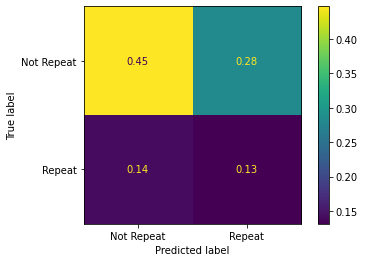

In [26]:
## We get the classification report.
print("\n AdaBoost Classification Report: \n")
print(classification_report(y_test,(best_lreg.predict_proba(X_test)[:,1] >=0.5).astype(int)))

## We get the confusion matrix for the best threshold of the best model. 
print("\n AdaBoost Confusion Matrix: \n")
matrix = confusion_matrix(y_test,(best_lreg.predict_proba(X_test)[:,1] >= 0.5).astype(int))
matrix = matrix.astype('float') / len(y_test)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Not Repeat','Repeat'])
disp.plot()
plt.show()


 GBCBoost Classification Report: 

              precision    recall  f1-score   support

           0       0.79      0.49      0.60      1929
           1       0.32      0.66      0.43       719

    accuracy                           0.53      2648
   macro avg       0.56      0.57      0.52      2648
weighted avg       0.66      0.53      0.56      2648


 GBCBoost Confusion Matrix: 



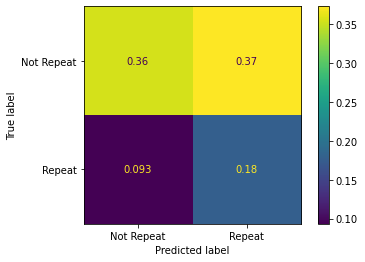

In [27]:
## We get the classification report.
print("\n GBCBoost Classification Report: \n")
print(classification_report(y_test,(ada_best.predict_proba(X_test)[:,1] >=0.5).astype(int)))

## We get the confusion matrix for the best threshold of the best model. 
print("\n GBCBoost Confusion Matrix: \n")
matrix = confusion_matrix(y_test,(ada_best.predict_proba(X_test)[:,1] >= 0.5).astype(int))
matrix = matrix.astype('float') / len(y_test)
disp = ConfusionMatrixDisplay(matrix, display_labels=['Not Repeat','Repeat'])
disp.plot()
plt.show()

## Feature Importances:

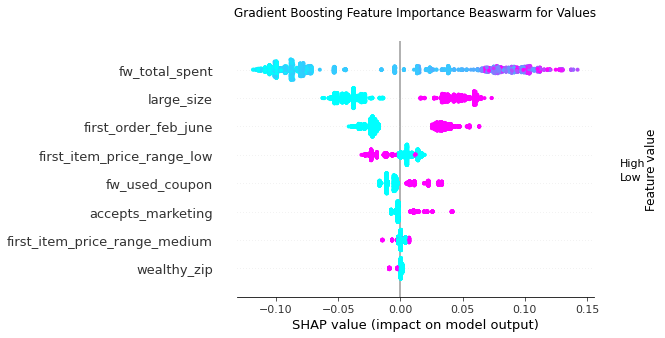

In [28]:
plt.title('Gradient Boosting Feature Importance Beaswarm for Values',pad = 25)
explainer = shap.Explainer(gbc_best)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values, color = plt.get_cmap("cool"))